In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Pre-req steps: from 01_exploration.ipynb

In [45]:
# get califronia housing data, and get shape, features
housing = fetch_california_housing(as_frame = True)

# convert the housing data into data frame in pandas
df = housing.frame

# features
X = df.drop(columns=["MedHouseVal"])
# goal
y = df['MedHouseVal']


scaler = StandardScaler()

# using random_state to 2 get consistent results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# normalize features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# polynomial
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly  = poly.transform(X_test_scaled)

feature_names = poly.get_feature_names_out(X_train.columns)

X_train_poly_df = pd.DataFrame(
    X_train_poly,
    columns=feature_names,
    index=X_train.index
)

# log feature engineering
cols_to_log = ["MedInc", "AveRooms", "AveBedrms", "Population", "AveOccup"]

X_train_log = X_train.copy()
X_test_log  = X_test.copy()

X_train_log[cols_to_log] = np.log1p(X_train_log[cols_to_log])
X_test_log[cols_to_log]  = np.log1p(X_test_log[cols_to_log])

X_train_log_scaled = scaler.fit_transform(X_train_log)
X_test_log_scaled  = scaler.transform(X_test_log)

# 3. Model Training

In [46]:
res = []
pred_vals = []

## 3.1 Linear Regression (baseline)

In [47]:
# linear regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

pred = lr.predict(X_test_scaled)

# evaluation
lr_rmse = mean_squared_error(y_test, pred) ** 0.5
lr_mae = mean_absolute_error(y_test, pred)
lr_r2 = r2_score(y_test, pred)

res.append({
    "Model": f"Linear Regression",
    "RMSE": lr_rmse,
    "MAE": lr_mae,
    "R2": lr_r2
})

pred_vals.append(pd.DataFrame({
    "Model": f"Linear Regression",
    "Actual": y_test.values,
    "Predicted": pred 
}))


## 3.2 Ridge Regression (regularized)

In [48]:
alpha = [0.1, 1, 10, 100]

for alph in alpha:
    # model
    ridge = Ridge(alpha=alph)
    ridge.fit(X_train_scaled, y_train)
    
    pred = ridge.predict(X_test_scaled)

    # evaluation
    rmse = mean_squared_error(y_test, pred) ** 0.5
    mae  = mean_absolute_error(y_test, pred)
    r2   = r2_score(y_test, pred)

    res.append({
        "Model": f"Ridge (alpha={alph})",
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    })

    pred_vals.append(pd.DataFrame({
        "Model": f"Ridge (alpha={alph})",
        "Actual": y_test.values,
        "Predicted": pred 
    }))


## 3.3 Polynomial + Linear Regression

In [49]:
lr = LinearRegression()
lr.fit(X_train_poly, y_train)

pred = lr.predict(X_test_poly)

rmse = mean_squared_error(y_test, pred) ** 0.5
mae  = mean_absolute_error(y_test, pred)
r2   = r2_score(y_test, pred)

res.append({
    "Model": f"Polynomial+Linear",
    "RMSE": rmse,
    "MAE": mae,
    "R2": r2
})

pred_vals.append(pd.DataFrame({
    "Model": f"Polynomial+Linear",
    "Actual": y_test.values,
    "Predicted": pred 
}))

## 3.4 Log + Ridge

In [50]:
alpha = [0.1, 1, 10, 100]

for alph in alpha:
    ridge = Ridge(alpha=alph)
    ridge.fit(X_train_log_scaled, y_train)

    pred = ridge.predict(X_test_log_scaled)

    rmse = mean_squared_error(y_test, pred) ** 0.5
    mae  = mean_absolute_error(y_test, pred)
    r2   = r2_score(y_test, pred)

    res.append({
        "Model": f"Log+Ridge (alpha={alph})",
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    })

    pred_vals.append(pd.DataFrame({
        "Model": f"Log+Ridge (alpha={alph})",
        "Actual": y_test.values,
        "Predicted": pred 
    }))

# 4. Model Evaluation

## 4.1 Comparison Table/Chart

In [51]:
results_df = pd.DataFrame(res).sort_values("RMSE").reset_index(drop=True)

styled = (results_df.style
          .format({"RMSE": "{:.3f}", "MAE": "{:.3f}", "R2": "{:.3f}"})
)
styled


,Model,RMSE,MAE,R2
0,Log+Ridge (alpha=0.1),0.716,0.534,0.619
1,Log+Ridge (alpha=1),0.716,0.534,0.619
2,Log+Ridge (alpha=10),0.716,0.534,0.619
3,Log+Ridge (alpha=100),0.717,0.535,0.618
4,Polynomial+Linear,0.720,0.469,0.615
5,Linear Regression,0.733,0.536,0.601
6,Ridge (alpha=0.1),0.733,0.536,0.601
7,Ridge (alpha=1),0.733,0.536,0.601
8,Ridge (alpha=10),0.733,0.536,0.601
9,Ridge (alpha=100),0.734,0.536,0.600


## 4.2 Predictions vs Actual Plot

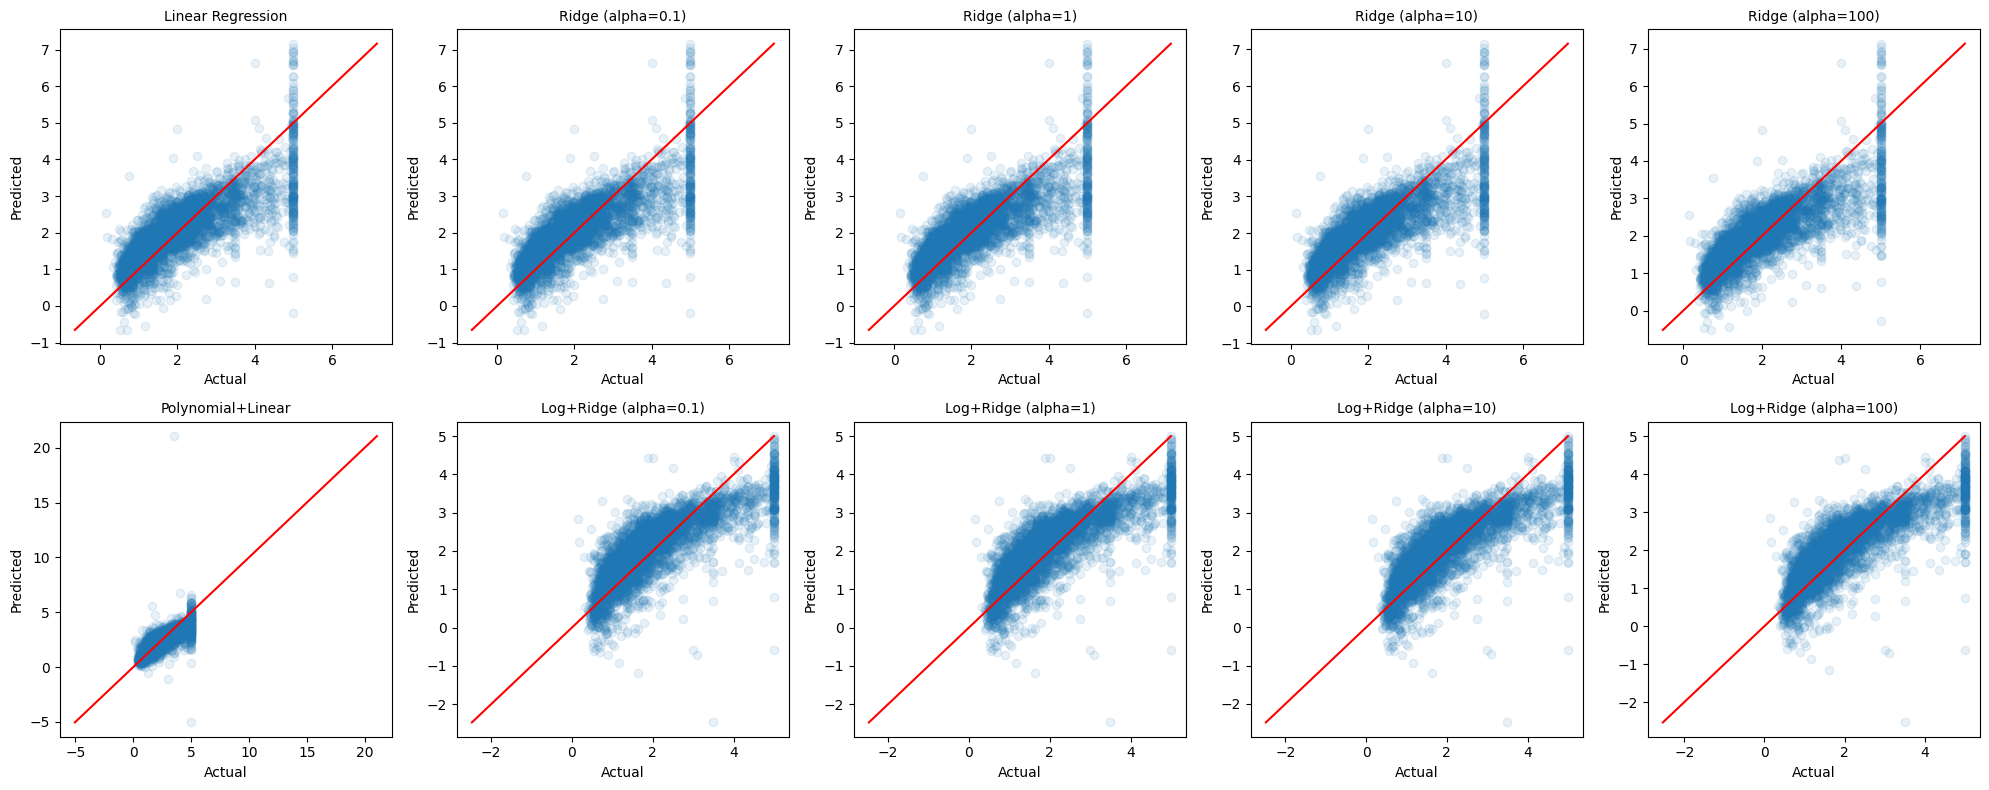

In [52]:
n = len(pred_vals)
ncols = 5
nrows = 2

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
axes = axes.flatten()

for i, df_m in enumerate(pred_vals):
    ax = axes[i]
    model_name = df_m["Model"].iloc[0]

    ax.scatter(df_m["Actual"], df_m["Predicted"], alpha=0.1)
    ax.set_title(model_name, fontsize=10)
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")

    # 45-degree line
    mn = min(df_m["Actual"].min(), df_m["Predicted"].min())
    mx = max(df_m["Actual"].max(), df_m["Predicted"].max())
    ax.plot([mn, mx], [mn, mx], color='red')

plt.tight_layout()
plt.show()

## 4.3 Residual Plot for Best Model

Best model: Log+Ridge (alpha=0.1) R2 = 0.6194346963799375


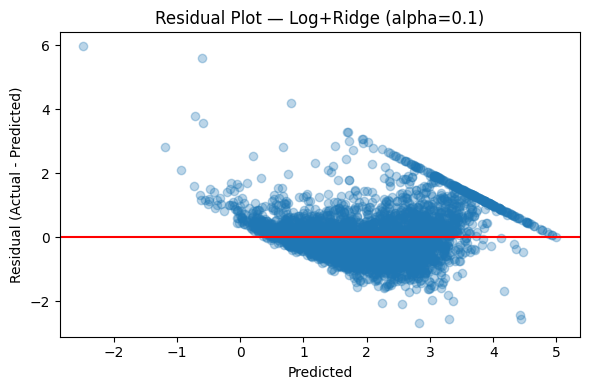

In [54]:
# finding best model
best = max(res, key=lambda d: d["R2"])
best_name = best["Model"]
print("Best model:", best_name, "R2 =", best["R2"])

df_best = next(df for df in pred_vals if df["Model"].iloc[0] == best_name)

# plot
residuals = df_best["Actual"] - df_best["Predicted"]

plt.figure(figsize=(6, 4))
plt.scatter(df_best["Predicted"], residuals, alpha=0.3)
plt.axhline(0, color="red")
plt.xlabel("Predicted")
plt.ylabel("Residual (Actual - Predicted)")
plt.title(f"Residual Plot — {df_best['Model'].iloc[0]}")
plt.tight_layout()
plt.show()

# 5. Analysis 

## 5.1 Feature Importance Analysis

8


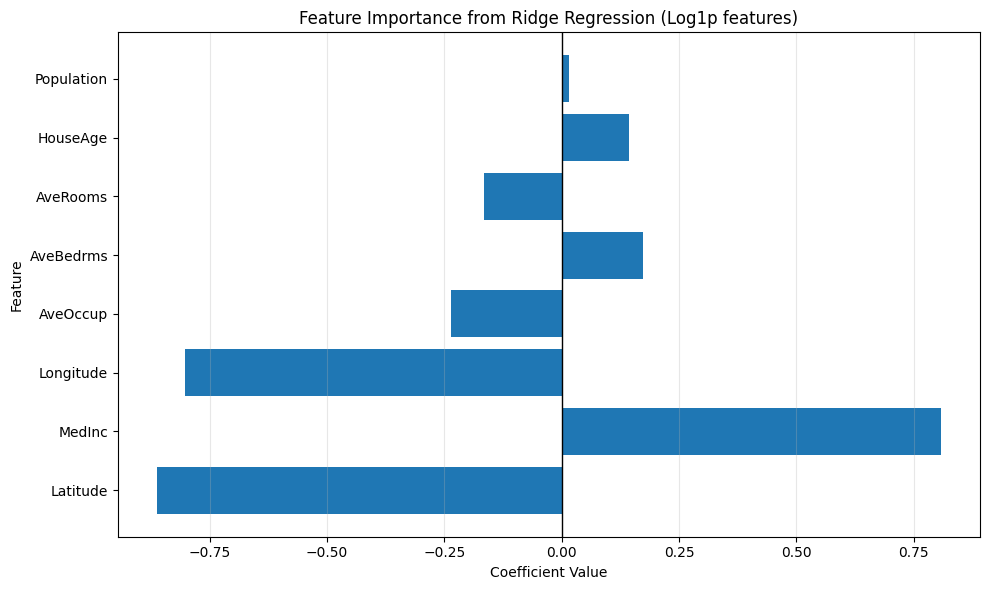

In [61]:
ridge = Ridge(alpha=0.1)
ridge.fit(X_train_log_scaled, y_train)

pred = ridge.predict(X_test_log_scaled)

feature_names_log = X_train_log.columns

feature_importance = pd.DataFrame({
    'Feature': feature_names_log,
    'Coefficient': ridge.coef_
})

feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)
print(len(feature_importance))

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance from Ridge Regression (Log1p features)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 5.2 Error Analysis (where does model fail?)

In [ ]:
r2 = r2_score(y_test, pred)

train_r2_ridge = r2_score(y_train, ridge.predict(X_train_log_scaled))
print(f"\nOverfitting check:")
print(f"  Training R²: {train_r2_ridge:.4f}")
print(f"  Test R²: {r2:.4f}")
print(f"  Gap: {(train_r2_ridge - r2):.4f}")


Overfitting check:
  Training R²: 0.6283
  Test R²: 0.6194
  Gap: 0.0089


In [ ]:
pred = ridge.predict(X_test_log_scaled)
residual = y_test.values - pred
abs_error = np.abs(residual)

err_df = X_test_log.copy()
err_df["Actual"] = y_test.values
err_df["Predicted"] = pred
err_df["Residual"] = residual
err_df["AbsError"] = abs_error

err_df.sort_values("AbsError", ascending=False).head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Actual,Predicted,Residual,AbsError
16669,1.660872,46.0,2.310248,0.836248,8.784622,6.221507,35.32,-120.70,3.50000,-2.477984,5.977984,5.977984
6688,0.405398,28.0,2.160724,1.054649,4.962845,1.719304,34.15,-118.08,5.00001,-0.596708,5.596718,5.596718
16642,0.532098,19.0,1.231159,0.754235,7.495542,1.343666,35.30,-120.67,5.00001,0.797207,4.202803,4.202803
20527,0.902314,7.0,1.509793,0.702036,8.407378,2.291211,38.54,-121.79,3.10000,-0.705092,3.805092,3.805092
16643,0.707937,20.0,1.223325,0.594575,8.181720,2.687404,35.32,-120.65,3.00000,-0.583952,3.583952,3.583952


In [70]:
err_corr = err_df.drop(columns=["Actual","Predicted","Residual"]).corr(numeric_only=True)["AbsError"] \
                 .sort_values(ascending=False)
err_corr


AbsError      1.000000
MedInc        0.120779
HouseAge      0.087670
AveBedrms     0.084044
AveRooms      0.068726
Latitude     -0.021948
Longitude    -0.028453
AveOccup     -0.082322
Population   -0.179913
Name: AbsError, dtype: float64

## 5.3 Interpretation of Results

- The result shows that Ridge Regression (alpha = 0.1) with Log transformations had the best result with $R^2$ = 0.619
- The best feature to predict the median house value is MedInc
- The model did not overfit nor underfit as the gap between the trained data's $R^2$ and test data's $R^2$ is narrow
- The error correlation states that as MedInc goes up, the Ridge model tends to make larger errors
- The error correlation states that as lower Population, the Ridge model tends to make larger errors
- However, these are still rather small correlations, so the relationship exists but isn't huge

## 5.4 Recommendations

- For future improvements to predict the Median house values, using different model may improve the $R^2$
- Using Polynomial + Ridge may also improve the overall result
- Having different features or mixture of features such as (RoomsPerHousehold = AveRooms/AveOccup) may improve the result as well